# Building A Handwritten Digits Classifier

In this project, we'll classify images with the dataset [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI. Meanwhile, we will explore the effectiveness of deep, feedforward neural networks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

from sklearn.datasets import load_digits

In [2]:
# load data
data = load_digits(return_X_y = True)
images = data[0]
labels = data[1]

Let's print some images from our data set.

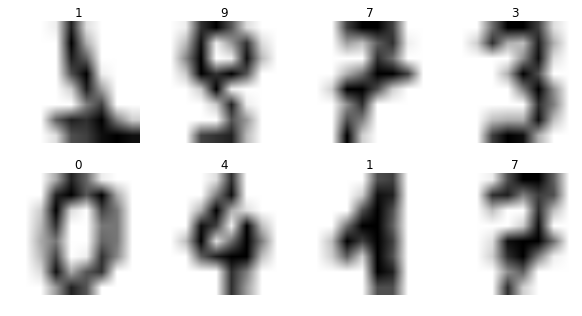

In [3]:
## show image
fig = plt.figure(figsize = (10,10))

# id of target images
image_ids = [[0,100,200,300],[1000,1100,1200,1300]]

# iterate row
for i in range(2):
    # iterate column
    for j in range(4):
        # call image
        nid = image_ids[i][j]
        image = images[nid]
        image = image.reshape(8,8)
      
        # print image
        ax = fig.add_subplot(i+1, 4, j+1)
        ax.imshow(image, cmap='gray_r')
        plt.title(labels[nid])
        plt.axis('off')

## Prediction with KNN

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm makes no such assumption. This allows them to capture nonlinearity in the data. Therefore we will use k-nearest neighbors to find the label with the most nearby observations and assigns that as the prediction for the unseen observation.

We experiment with different values for k with 4-fold cross validation.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [5]:
def train_knn(X, y, k):
    model = KNeighborsClassifier(k)
    model.fit(X, y)
    return model

def test(model, X):
    prediction = model.predict(X)    
    return prediction

def cross_validate_knn(X, y, nfold, k):
    kf = KFold(n_splits = nfold, shuffle = True, random_state = 1)
    accuracy_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = train_knn(X_train, y_train, k)
        prediction = test(model, X_test)
        
        accuracy = accuracy_score(y_test, prediction)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

def cross_validate_knn_train(X, y, nfold, k):
    kf = KFold(n_splits = nfold, shuffle = True, random_state = 1)
    accuracy_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = train_knn(X_train, y_train, k)
        prediction = test(model, X_train)
        
        accuracy = accuracy_score(y_train, prediction)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

In [6]:
# transform into dataframe to fit model
images = pd.DataFrame(images)
labels = pd.DataFrame(labels)

In [7]:
start_time = time.time()

# list of accuracy
acc_k = []
for i in range(2,11):
    acc = cross_validate_knn(images, labels, 4, i)
    acc_k.append(acc)

# list of accuracy for train set
acc_k_train = []
for i in range(2,11):
    acc = cross_validate_knn_train(images, labels, 4, i)
    acc_k_train.append(acc)
    
print("--- %s seconds ---" % (time.time() - start_time))

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- 11.139619588851929 seconds ---


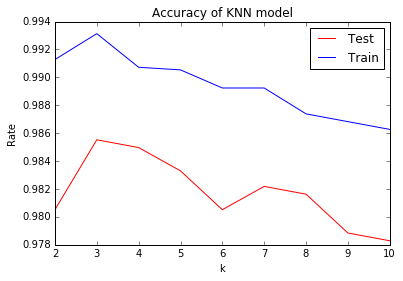

In [8]:
plt.plot(range(2,11), acc_k, c='red')
plt.plot(range(2,11), acc_k_train, c='blue')
plt.xlabel('k')
plt.ylabel('Rate')
plt.title('Accuracy of KNN model')
plt.legend(['Test', 'Train'], loc='best')

We get the best accuracy, 0.986 when k=3. If we increase the number of neighborhood, the accuracy decreases.

## Prediction with neural network with 1 layer

Let's now try a neural network with a single hidden layer. We will fit the model with different numbers of neurons to examine their performance. Then we will predict the result from both training and testing set so that to evaluate overfitting.

In [9]:
from sklearn.neural_network import MLPClassifier

def train_nn(X, y, neurons):
    model = MLPClassifier(hidden_layer_sizes = neurons,
                          max_iter=1000,
                          activation = 'relu')
    model.fit(X, y)
    return model

# validation with test set
def cross_validate_nn(X, y, nfold, neurons):
    kf = KFold(n_splits = nfold, shuffle = True, random_state = 0)
    accuracy_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = train_nn(X_train, y_train, neurons)
        prediction = test(model, X_test)
        
        accuracy = accuracy_score(y_test, prediction)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

In [10]:
# validation with train set
def cross_validate_nn_train(X, y, nfold, neurons):
    kf = KFold(n_splits = nfold, shuffle = True, random_state = 0)
    accuracy_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = train_nn(X_train, y_train, neurons)
        prediction = test(model, X_test)
        
        accuracy = accuracy_score(y_test, prediction)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

In [11]:
def compare(n_neurons, n_fold):
    # test set
    acc_list = []
    for n in n_neurons:
        acc = cross_validate_nn(images, labels, 4, n)
        acc_list.append(acc)
    
    # train set
    acc_list_train = []
    for n in n_neurons:
        acc = cross_validate_nn_train(images, labels, 4, n)
        acc_list_train.append(acc)
        
    return acc_list, acc_list_train

In [12]:
start_time = time.time()
n_neurons = [(8,),(16,),(32,),(64,),(128,),(256,)]
acc_list, acc_list_train = compare([(8,),(16,),(32,),(64,),(128,),(256,)],
                                   n_fold = 4)
print("--- %s seconds ---" % (time.time() - start_time))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- 498.2520840167999 seconds ---


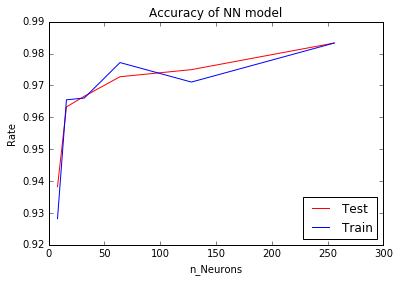

In [14]:
plt.plot(n_neurons, acc_list, c='red')
plt.plot(n_neurons, acc_list_train, c='blue')
plt.xlabel('n_Neurons')
plt.ylabel('Rate')
plt.title('Accuracy of NN model')
plt.legend(['Test', 'Train'], loc='best')

The accuracy becomes stable when we have 64 neurons and we don't have a serious overfitting problem as knn. However, the neural network models take a much longer time than knn but the accuracy is not better than knn in general.

## Prediction with neural network with 2 layers

We'll try to enhance the flexibility of neural network model by adding 1 more layer and check if the accuracy will be improved. Since 64 neurons have already a pretty good and stable accuracy in our 1 layer model, we will use 2 layers starting with 64 neurons to reduce the running time.

In [15]:
start_time = time.time()
n_neurons = [(64,64),(128,128),(256,256)]
acc_list_2, acc_list_train_2 = compare(n_neurons, n_fold = 4)
print("--- %s seconds ---" % (time.time() - start_time))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- 520.2907826900482 seconds ---


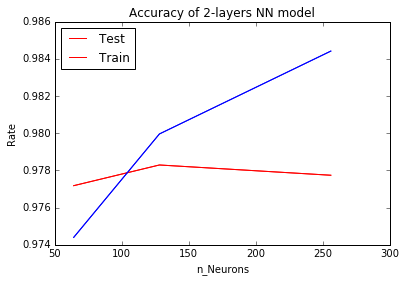

In [21]:
plt.plot(n_neurons, acc_list_2, c='red')
plt.plot(n_neurons, acc_list_train_2, c='blue')
plt.xlabel('n_Neurons')
plt.ylabel('Rate')
plt.title('Accuracy of 2-layers NN model')
plt.legend(['Test', 'Train'], loc='best')

The accuracy on the test set does not improve even though we add one more layer.

## Prediction with neuarl network with 3 layers

How about 3 layers?

In [22]:
start_time = time.time()
n_neurons = [(10,10,10),
             (64,64,64),
             (128,128,128)]
acc_list_3, acc_list_train_3 = compare(n_neurons,
                                       n_fold = 6)
print("--- %s seconds ---" % (time.time() - start_time))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- 326.1579451560974 seconds ---


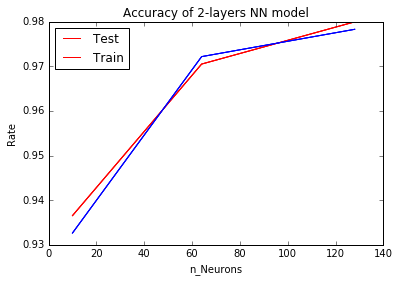

In [23]:
plt.plot(n_neurons, acc_list_3, c='red')
plt.plot(n_neurons, acc_list_train_3, c='blue')
plt.xlabel('n_Neurons')
plt.ylabel('Rate')
plt.title('Accuracy of 2-layers NN model')
plt.legend(['Test', 'Train'], loc='best')

Still, the accuracy stays almost the same as previous models with fewer layers, but the difference in accuracy is very close. This implies the 3-layer model has greatly improved the problem of overfitting.

# Summary

Both KNN and neural network models provide a good prediction on our handwritten digits classification task. KNN is faster in execute time and neural networks with multiple layers have less bias.